In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

np.random.seed(1234)

In [3]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NVIDIA GeForce GTX 1650
Using device: cuda


## Deep Neural Network

In [23]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [37]:
class PINN():
    def __init__(self, layers, x, q, lb, rb):

        self.w_pde = 1.0
        self.w_bc = 1.0

        self.x = x
        self.q = q

        self.lb = lb
        self.rb = rb

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.1,
            max_iter=2000,
            max_eval=2000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=0.01)
        self.iter = 0

    def model_value(self, x):
        out = self.dnn(x)
        u = out[:,0].view(-1, 1)
        m = out[:,1].view(-1, 1)
        return u, m
    
    def boundary_cond(self, cond, u, u_x, m, m_x):
        bc_loss = 0

        match cond:
            case 'pinned':
                bc_loss += u**2 + m**2
            case 'fixed':
                bc_loss += u**2 + u_x**2
            case 'free':
                bc_loss += m**2 + m_x**2
            case 'roller':
                bc_loss += u_x**2 + m_x**2
        return bc_loss

    def loss_func(self, x):
        u, m = self.model_value(x)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        m_x = torch.autograd.grad(m, x, torch.ones_like(m), create_graph=True)[0]
        m_2x = torch.autograd.grad(m_x, x, torch.ones_like(m_x), create_graph=True)[0]

        # BC
        bc_loss = self.boundary_cond(self.lb, u[0], u_x[0], m[0], m_x[0])
        bc_loss += self.boundary_cond(self.rb, u[-1], u_x[-1], m[-1], m_x[-1])

        # PDE
        pde_loss = torch.mean(torch.pow(m_2x + self.q, 2))
        pde_loss += torch.mean(torch.pow(u_2x + m, 2))

        return pde_loss, bc_loss


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func(self.x)
        loss = self.w_pde*pde_loss + self.w_bc*bc_loss

        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
            print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func(self.x)
            loss = self.w_pde*pde_loss + self.w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()

            if epoch % 200 == 0:
                print(f"Epoch: {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u_c, m_c = self.model_value(x)
        u_c = u_c.detach().cpu().numpy()
        m_c = m_c.detach().cpu().numpy()
        return u_c, m_c

## Parameters

In [25]:
E = 70e9
I = 0.1**4 / 12 # Square cross section with lenght 0.1m
EI = E * I
print(EI)
L = 3.0
Q = -20000.0

583333.3333333335


## Exact solutions

In [26]:
q1 = lambda x: Q / (24*EI) * (x**4 - 4*L*x**3 + 6*L**2*x**2) # Fixed, free, constant q
q2 = lambda x: Q / (120*EI) * (x**5/L - 10*L*x**3 + 20*L**2*x**2) # Fixed, free, increasing q
q3 = lambda x: Q / (120*EI) * (-x**5/L + 5*x**4 - 10*L*x**3 + 10*L**2*x**2) # Fixed, free, decreasing q
q4 = lambda x: Q / (24*EI) * (x**4 - 2*x**3*L + x*L**3) # Pinned, pinned, constant q
q5 = lambda x: Q / EI * (x**5/(120*L) - x**3*L/36 + 7*L**3*x/360) # Pinned, pinned, increasing q
q6 = lambda x: Q / (180*EI) * (-3*x**5/L**2 + 15*x**4/L - 20*x**3 + 8*L**2*x) # Pinned, pinned, decreasing q (Seems to be the wrong formula)
q7 = lambda x: Q / (48*EI) * (2*x**4 - 5*L*x**3 + 3*L**2*x**2) # Fixed, pinned, constant q
exact_dict = {
    "fixed_free_constant": q1,
    "fixed_free_increasing": q2,
    "fixed_free_decreasing": q3,
    "pinned_pinned_constant": q4,
    "pinned_pinned_increasing": q5,
    "pinned_pinned_decreasing": q6,
    "fixed_pinned_constant": q7,
}

In [8]:
qx1 = lambda x: np.full_like(x, Q) # Constant
qx2 = lambda x: Q/L * x # Increasing
qx3 = lambda x: Q/L * (L - x) # Decrasing

In [42]:
# Model
p = 1000
x = np.random.uniform(0, L, p)
x = np.append(x, [0, L]) # Add boundary points
x = np.sort(x).reshape(-1, 1)
x_hat = x / L

q = qx1(x)
q0 = np.max(np.abs(q))
q_hat = q / q0
lb = 'fixed'
rb = 'pinned'

x_t = torch.tensor(x_hat, device=device, requires_grad=True).float()
q_t = torch.tensor(q_hat, device=device).float()
layers = [1] + 3*[20] + [2]

<Figure size 600x300 with 0 Axes>

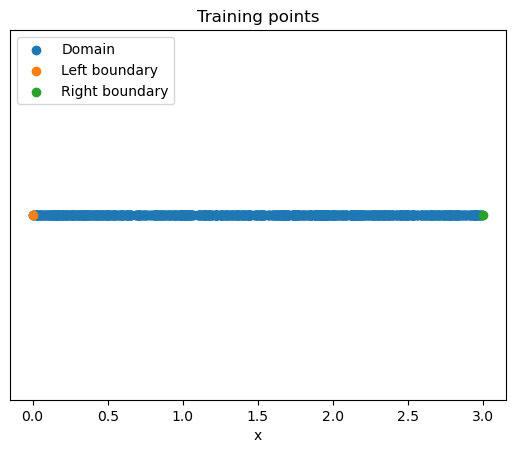

In [43]:
plt.figure(figsize=(6, 3))
fig, ax = plt.subplots()
ax.scatter(x[1:-1], np.zeros_like(x[1:-1]), label="Domain")
ax.scatter(x[0], np.zeros_like(x[0]), label="Left boundary")
ax.scatter(x[-1], np.zeros_like(x[-1]), label="Right boundary")
plt.title("Training points")
plt.xlabel("x")
ax.set_yticks([])
plt.legend(loc="upper left")

In [44]:
model = PINN(layers, x_t, q_t, lb, rb)
print(model.dnn)

DNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=2, bias=True)
  )
)


In [45]:
%%time
model.train(2000)

Epoch: 0, Loss: 1.028165e+00
PDE: 1.023394e+00, BC: 4.771027e-03
Epoch: 200, Loss: 2.728674e-03
PDE: 1.872343e-03, BC: 8.563313e-04
Epoch: 400, Loss: 1.642338e-05
PDE: 1.642187e-05, BC: 1.502203e-09
Epoch: 600, Loss: 1.548331e-05
PDE: 1.548133e-05, BC: 1.988012e-09
Epoch: 800, Loss: 1.350161e-05
PDE: 1.349907e-05, BC: 2.540347e-09
Epoch: 1000, Loss: 2.358936e-05
PDE: 2.358460e-05, BC: 4.763788e-09
Epoch: 1200, Loss: 1.952412e-05
PDE: 1.952319e-05, BC: 9.336312e-10
Epoch: 1400, Loss: 1.662348e-05
PDE: 1.642257e-05, BC: 2.009118e-07
Epoch: 1600, Loss: 2.948608e-05
PDE: 2.948383e-05, BC: 2.248452e-09
Epoch: 1800, Loss: 2.156162e-05
PDE: 2.156067e-05, BC: 9.516916e-10
Iter: 0, Loss: 4.270322e-05
PDE: 4.198474e-05, BC: 7.184773e-07
Iter: 100, Loss: 1.910523e-06
PDE: 1.876164e-06, BC: 3.435937e-08
CPU times: total: 14.6 s
Wall time: 33.8 s


In [46]:
x = np.linspace(0, L, 100).reshape(-1, 1)

u, m = model.predict(x/L)
u_pred = (L**4 * q0 / EI) * u
m_pred = (L**2 * q0) * m

exact_solution = exact_dict['fixed_pinned_constant']
u_exact = exact_solution(x)

u_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact,2)
abs_error = np.abs(u_pred - u_exact)
print(f"L2 Error: {u_error}")

L2 Error: 0.0007057650985769201


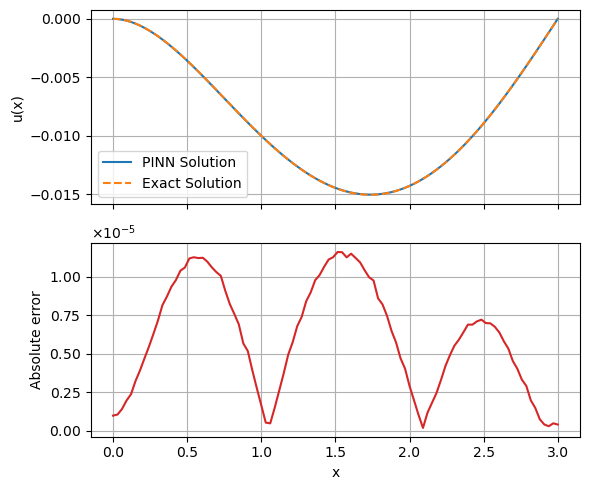

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax1.plot(x, u_pred, label="PINN Solution")
ax1.plot(x, u_exact, label="Exact Solution", linestyle="dashed")
ax1.set(ylabel='u(x)')
ax1.legend()
ax1.grid()

ax2.plot(x, abs_error, 'tab:red')
ax2.set(xlabel='x', ylabel='Absolute error')
ax2.grid()

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Defines when to switch to scientific notation

ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()